# Semi-Supervised Architope (Chaotic Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters
In Grid_Enhanced_NetworkGrid_Enhanced_Network.py file

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 3

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
lorenz input data               x         y          z
0      5.894076 -6.415820  -8.194456
1      4.821934 -4.429324  -8.263782
2      4.022918 -2.797976  -8.203039
3      3.441617 -1.433997  -8.064589
4      3.035476 -0.265226  -7.879283
...         ...       ...        ...
47995  8.339276  7.603378  27.769801
47996  8.266649  7.551238  27.659791
47997  8.196433  7.508691  27.543485
47998  8.129324  7.475957  27.422103
47999  8.065966  7.453155  27.296871

[48000 rows x 3 columns]
size training input data: (43200, 3)
size test input data: (4800, 3)
size training output data: (43200, 3)
size test output data: (4800, 3)
#================================================#
 Training Datasize: 43200 and test datasize: 4800.  
#================================================#
size training output data: (43200, 3)
size test output data: (4800, 3)


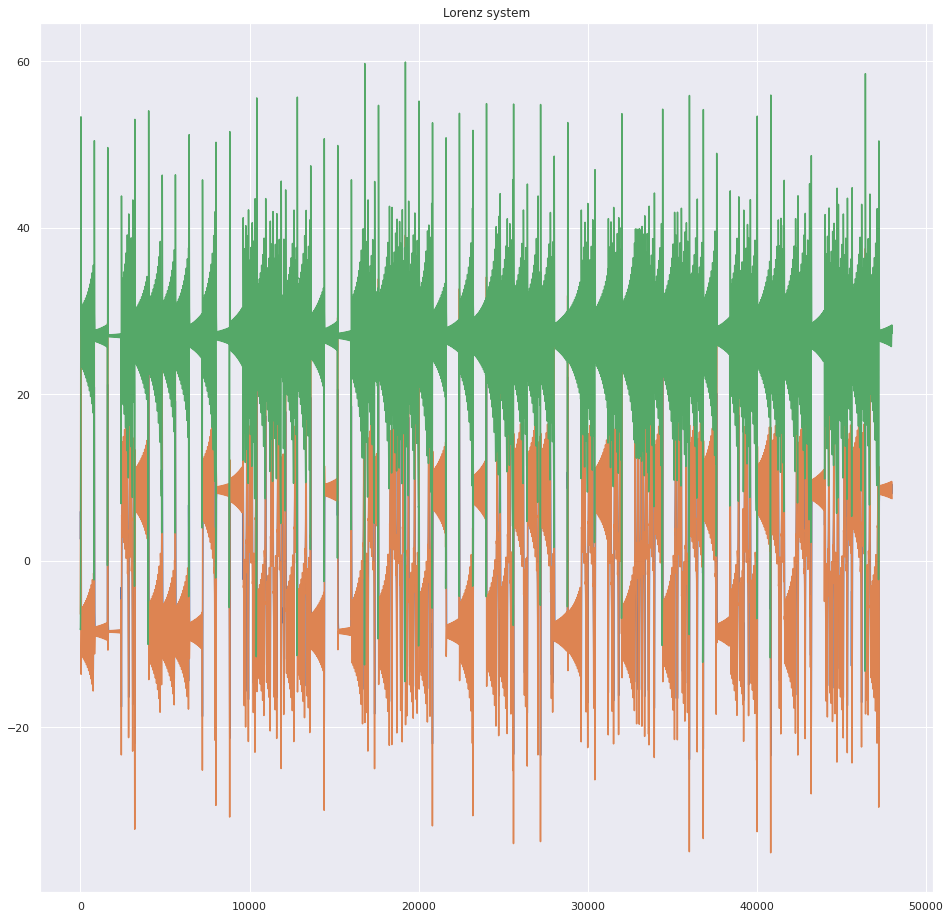

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid - here is set the Option_Function
exec(open('Grid_Enhanced_Network.py').read()) 
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Chaos_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

In [6]:
print(Option_Function)

lorenz


### Set Seed

In [7]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [8]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [9]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    # note this operation:',distance_matrix(X_train_in_shuffled,X_train_in_shuffled).shape)
    print('size of Data driven radius:',Delta_X.shape)
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print('pool train loop percentage:',(N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                #y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
                y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [10]:
import time
partitioning_time_begin = time.time()

In [11]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 10
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    if Option_Function == 'lorenz':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 15000
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [12]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regenerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size = min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts in the input are: ' + str(len(X_parts_list))+'.')
    print('X_parts_list:', X_parts_list)
    print('The_parts_listhe number of parts in the output are: ' + str(len(y_parts_list))+'.')
    print('y_parts_list:', y_parts_list)
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

size of Data driven radius: (43200,)
pool train loop percentage: 0.9865277777777778
pool train loop percentage: 0.962662037037037
pool train loop percentage: 0.9397685185185185
pool train loop percentage: 0.925162037037037
pool train loop percentage: 0.913449074074074
pool train loop percentage: 0.8998842592592593
pool train loop percentage: 0.8678935185185185
pool train loop percentage: 0.3396296296296296
pool train loop percentage: 0.26641203703703703
pool train loop percentage: 0.005509259259259259
pool train loop percentage: 0.003935185185185185
pool train loop percentage: 0.0030092592592592593
pool train loop percentage: 0.0018055555555555555
pool train loop percentage: 0.00030092592592592595
pool train loop percentage: 2.3148148148148147e-05
pool train loop percentage: 0.0
The_parts_listhe number of parts in the input are: 2.
X_parts_list: [              x          y          z
53    -6.839236 -11.119703  31.736388
54    -7.228739 -10.750087  31.660895
55    -7.545777 -10.376179 

In [13]:
#Iteration_Length = len(X_parts_list)
#N_modify = []
#for jj in range(Iteration_Length):
 #   N_modify = np.append(N_modify,(len(X_parts_list[jj])))
    
#print(N_modify)

In [14]:
partitioning_time = time.time() - partitioning_time_begin

In [15]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 2.


#### Building Training Predictions on each part (each part represent a different manifold) and Train the Deep Classifier
- Train locally (on each "naive part" and after on each "trained part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

In [16]:
epochs_training_interaction = 3
for ntrain_interaction in range(epochs_training_interaction):
    print('epochs for training interaction:',ntrain_interaction)
    #############################################################
    #############################################################
    ############--- Train each FFNN on each part ---#############
    #############################################################
    #############################################################
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('---------- Train each FFNN on each part ------------')
    print('---------------- Deep  Classifier ------------------')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')
    # Time-Elapse (Start) for Training on Each Part
    Architope_partition_training_begin = time.time()
    # Initialize running max for Parallel time
    Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
    # Initialize N_parameter counter for Architope
    N_params_Architope = 0
    #
    tf.compat.v1.disable_eager_execution()
    # Silly Coercsion for ICML rebuttle deadline timeline
    if Option_Function == 'Motivational_Example':
        Iteration_Length = len(X_parts_list) -1
    else:
        Iteration_Length = len(X_parts_list)
    #
    N_modify0 = []
    for kk in range(Iteration_Length):
        N_modify0 = np.append(N_modify0,(len(X_parts_list[kk])))
    #
    N_modify_tot = sum(N_modify0)
    #
    N_modify = []
    for jj in range(Iteration_Length):
        N_modify = np.append(N_modify,(len(X_parts_list[jj])/N_modify_tot))
    #
    print(N_modify)
    #
    # Train each part!
    for current_part in range(Iteration_Length):
        #==============#
        # Timer(begin) #
        #==============#
        current_part_training_time_for_parallel_begin = time.time()
        #
        Iteration_Length = len(X_parts_list)
        #
        #    
        # Initializations #
        #-----------------#
        # Reload Grid
        exec(open('Grid_Enhanced_Network.py').read())
        # Modify heights according to optimal (data-driven) rule (with threshold)
        ## current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
        ## print('N_ratios',N_ratios,'Iteration_Length',Iteration_Length)
        ##################################################################################################
        ##################################################################################################
        ##################################################################################################
        # Modify heights of the ANN in order to make it more interpretable for our approach
        current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height']))#*N_modify[current_part])
        ##################################################################################################
        ##################################################################################################
        current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
        current_height = np.maximum(current_height,current_height_threshold)
        current_height = current_height.astype(int).tolist()
        # current_height = X_parts_list.shape[curerent_part,row]
        param_grid_Vanilla_Nets['height'] = current_height
        # Automatically Fix Input Dimension
        param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
        param_grid_Vanilla_Nets['output_dim'] = [3]
        print('param_grid_Vanilla_Nets - input dim:',param_grid_Vanilla_Nets['input_dim'])
        print('param_grid_Vanilla_Nets - output dim:',param_grid_Vanilla_Nets['output_dim'])
        #
        # Update User #
        #-------------#
        print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
        print('Heights to iterate over: '+str(current_height))
        #
        # Generate Prediction(s) on current Part #
        #----------------------------------------#
        # Failsafe (number of data-points)
        CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
        # Train Network
        y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                          n_jobs = n_jobs,
                                                                                          n_iter = n_iter, 
                                                                                          param_grid_in = param_grid_Vanilla_Nets, 
                                                                                          X_train= X_parts_list[current_part], 
                                                                                          y_train=y_parts_list[current_part],
                                                                                          X_test_partial=X_train,
                                                                                          X_test=X_test,
                                                                                          NOCV=True)
        #put shape formats in order
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_train_full_loop.shape = (y_hat_train_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_test_full_loop.shape = (y_hat_test_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        print('y_train shape:',y_train.shape)
        print('y_hat_train_full_loop shape:',y_hat_train_full_loop.shape)
        print('y_test shape:',y_test.shape)
        print('y_hat_test_full_loop shape:',y_hat_test_full_loop.shape)
        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
            print('training_quality shape:',training_quality.shape)
            #training_quality = training_quality.reshape(training_quality.shape[0],1)
            #print('training_quality shape after reshape:',training_quality.shape)
            #
            # Save Predictions
            predictions_train = y_hat_train_full_loop
            #predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
            predictions_test = y_hat_test_full_loop
            #predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
            #
            #        
        ## If not first prediction we append to already initialized dataframes
        else:
            # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],predictions_train.shape[1])
            print('y_hat_train_loop shape:',y_hat_train_loop.shape)
            predictions_train = np.dstack([predictions_train,y_hat_train_loop]) # stack along a new axis in last axis of the result
            print('predictions_train shape:',predictions_train.shape)
            y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],predictions_test.shape[1])
            print('y_hat_test_loop shape:',y_hat_test_loop.shape)
            predictions_test = np.dstack([predictions_test,y_hat_test_loop]) # stack along a new axis in last axis of the result
            print('predictions_test shape:',predictions_test.shape)
            #
            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            print('prediction_errors shape:', prediction_errors.shape)
            training_quality = np.dstack([training_quality,prediction_errors.reshape(training_quality.shape[0],training_quality.shape[1])])
            print('training_quality shape:', training_quality.shape)
            #
        #============#
        # Timer(end) #
        #============#
        current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
        Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)
        #
        #============---===============#
        #
        # N_parameter Counter (Update) #
        #------------===---------------#
        N_params_Architope = N_params_Architope + N_params_Architope_loop
        #
    # Update User
    #-------------#
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('Feature Generation (Learning Phase): Score Generated')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')
    #
    # Time-Elapsed Training on Each Part
    Architope_partition_training = time.time() - Architope_partition_training_begin
    print('Time-Elapsed Training on Each Part:', Architope_partition_training)
    #
    #############################################################
    #############################################################
    ###################-- Train Classifier --####################
    #############################################################
    #############################################################
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('---------------- Train Classifier ------------------')
    print('---------------- Deep  Classifier ------------------')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')
    #Deep Classifier
    #Prepare Labels/Classes
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training_begin = time.time()
    # Initialize Classes Labels
    partition_labels_training_integers = np.argmin(np.sum(training_quality, axis=1),axis=-1)
    print('partition_labels_training_integers shape:', partition_labels_training_integers.shape)
    print('partition_labels_training_integers:', partition_labels_training_integers)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    print('partition_labels_training shape:', partition_labels_training.shape)
    print('partition_labels_training:', partition_labels_training)
    # Build Classes
    for part_column_i in range(1,(training_quality.shape[-1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    # Convert to integers
    partition_labels_training = partition_labels_training+0
    partition_labels_training_new = np.zeros(predictions_train.shape)
    for jj in range(X_train.shape[1]):
        partition_labels_training_new[:,jj,:] = partition_labels_training
    #
    print('partition_labels_training_new shape:', partition_labels_training_new.shape)
    print('partition_labels_training_new:', partition_labels_training_new)
    #Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.
    print('Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary')
    # Re-Load Hyper-parameter Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Re-Load Helper Function(s)
    exec(open('Helper_Functions.py').read())
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    print('input_dim:', X_train.shape[1])
    param_grid_Deep_Classifier['output_dim'] = [partition_labels_training_new.shape[-1]]
    print('output_dim:', partition_labels_training_new.shape[-1])
    param_grid_Deep_Classifier['epochs'] = [int(np.maximum(round(param_grid_Deep_Classifier['epochs'][0]),min_epochs_classifier))]
    print('# epochs:',param_grid_Deep_Classifier['epochs'])
    print('---- Train Deep Classifier ----')
    # Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                             n_jobs = n_jobs, 
                                                                                                             n_iter =n_iter, 
                                                                                                             param_grid_in=param_grid_Deep_Classifier, 
                                                                                                             X_train = X_train.values, 
                                                                                                             y_train = partition_labels_training.values,
                                                                                                             X_test = X_test.values)
    # COMMENT: .values() is used to convert the Pandas Dataframes here, and not in the vanilla ffNNs, since the former is coded in Keras and the latter in tensorflow.
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin
    
    #GET BINARY CLASSES (DISCONTINUOUS UNIT)
    # Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    #### OLD: Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
    # Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    #### OLD: Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)
    
    #UPDATE to improve the interaction between the clustering and the regression problem
    # Train
    predicted_classes_train_update = np.zeros(predictions_train.shape)
    for jj in range(X_train.shape[1]):
        predicted_classes_train_update[:,jj,:] = predicted_classes_train
    
    
    print('predicted_classes_train shape:', predicted_classes_train.shape)
    print('predicted_classes_train_update shape:', predicted_classes_train_update.shape)
    print('predictions_train shape :', predictions_train.shape)
    
    # Test
    predicted_classes_test_update = np.zeros(predictions_test.shape)
    for jj in range(X_test.shape[1]):
        predicted_classes_test_update[:,jj,:] = predicted_classes_test
    
    
    print('predicted_classes_test shape:', predicted_classes_test.shape)
    print('predicted_classes_test_update shape:', predicted_classes_test_update.shape)
    print('predictions_test shape :', predictions_test.shape)
    
    X_parts_list = list()
    y_parts_list = list()
    #X_parts_list = np.zeros(predictions_test.shape)
    #y_parts_list = np.zeros(predictions_test.shape)
    num_kkkk = predictions_test[1,1,:].shape
    num_kkkk = int(num_kkkk[0])
    for kkkk in range(num_kkkk):
        X_manifold = []
        Elementindex = []
        elementindex = int(-1)
        while True:
            try:
                predicted_classes_train_update1 = []
                predicted_classes_train_update1 = predicted_classes_train_update[:,1,kkkk]
                predicted_classes_train_update1 = predicted_classes_train_update1.tolist()
                elementindex = predicted_classes_train_update1.index(1,elementindex+1) #here we can fix the dimension 1 because in this step procedure we look for only the occurence of a model
                Elementindex.append(elementindex)
            except  ValueError:
                break
        #print("Element index ", Elementindex)
        X_manifold = X_train.iloc[Elementindex]
        y_manifold = data_y.iloc[Elementindex]
        print('X_manifold',X_manifold)
        print('=============================')
        print('=============================')
        print('y_manifold',y_manifold)
        print('=============================')
        print('=============================')
        #X_manifold = X_manifold.tolist()
        X_parts_list.append(X_manifold)
        y_parts_list.append(y_manifold)
        print('X_parts_list',X_parts_list)
        print('=============================')
        print('=============================')
        print('y_parts_list',y_parts_list)
        #print('kkkk',kkkk)
        
    #print('X_manifold',X_manifold)
    #print('X_parts_list',X_parts_list)
    #print('=============================')
    #print('=============================')
    #print('y_manifold',y_manifold)
    #print('y_parts_list',y_parts_list)
    #print('kkkk',kkkk)
        
        #y_parts_list[:,:,kkkk] = data_y.iloc[Elementindex]
        #X_train_list.append(X_train[Elementindex,:])
        #print('X_train_list_shape',X_train_list.shape)
        #print('X_train_list',X_train_list)
    
    

epochs for training interaction: 0
 
 
 
----------------------------------------------------
---------- Train each FFNN on each part ------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
[0.52827612 0.47172388]
param_grid_Vanilla_Nets - input dim: [3]
param_grid_Vanilla_Nets - output dim: [3]
Status: Current part: 0 out of : 2 parts.
Heights to iterate over: [3]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 22821 samples
Epoch 1/100
22821/22821 [==============================] - 1s 57us/sample - loss: 17.9176 - mse: 1027.3450 - mae: 17.9176 - mape: 451.0998
Epoch 2/100
22821/22821 [==============================] - 1s 44us/sample - loss: 12.2213 - mse: 646.1645 - mae: 12.2213 - mape: 311.3693
Epoch 3/100
22821/22821 [==============================] - 1s 47us/sample - loss: 11.8667 - mse: 620.4457 - mae: 11.8667 - mape: 416.2527
Epoch 4/100
22821/22821 [===================

In [17]:
print('predictions_test shape',predictions_test[1,1,:].shape)
#A = predictions_test[1,1,:].shape
#A = int(A[0])

predictions_test shape (2,)


predicted_classes_train shape: (43200, 2)
predicted_classes_train_update shape: (43200, 3, 2)
predictions_train shape : (43200, 3, 2)
predicted_classes_test shape: (4800, 2)
predicted_classes_test_update shape: (4800, 3, 2)
predictions_test shape : (4800, 3, 2)
X_manifold                x          y          z
38     12.590669  -8.746903  46.840059
39     10.460896 -10.689176  44.499428
40      8.379223 -12.026048  42.271726
41      6.392696 -12.881305  40.252118
42      4.532364 -13.371074  38.486674
...          ...        ...        ...
43195  -7.780484  -4.714503  29.862659
43196  -7.480086  -4.542631  29.425034
43197  -7.193820  -4.409718  28.974508
43198  -6.923939  -4.313410  28.515588
43199  -6.672245  -4.251207  28.052219

[23254 rows x 3 columns]
y_manifold                 x           y           z
38    -212.977268 -194.227353 -234.063105
39    -208.167305 -133.687172 -222.770173
40    -198.652660  -85.525747 -201.960833
41    -186.033241  -48.976836 -176.544465
42    -171.6

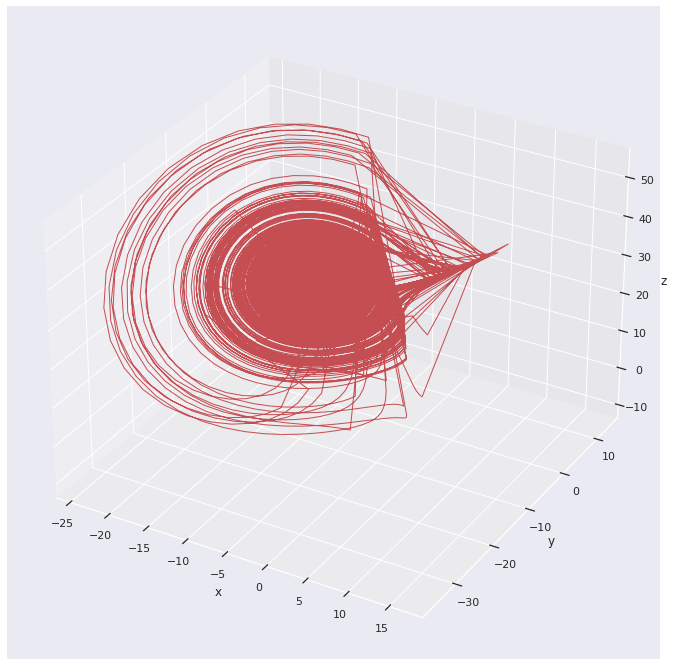

<Figure size 864x864 with 0 Axes>

X_manifold                x         y          z
0       5.894076 -6.415820  -8.194456
1       4.821934 -4.429324  -8.263782
2       4.022918 -2.797976  -8.203039
3       3.441617 -1.433997  -8.064589
4       3.035476 -0.265226  -7.879283
...          ...       ...        ...
43124  15.285551  4.044438  44.901879
43125  14.094111  1.583600  44.126010
43126  12.798812 -0.521441  43.032880
43127  11.444468 -2.254161  41.732278
43128  10.071676 -3.628073  40.320165

[19946 rows x 3 columns]
y_manifold                 x           y           z
0     -107.214196  198.649618   -6.932580
1      -79.901562  163.134784    6.074352
2      -58.130086  136.397868   13.844969
3      -40.614143  116.877103   18.530631
4      -26.328560  103.240137   21.460616
...           ...         ...         ...
43124 -119.143934 -246.083768  -77.586947
43125 -129.529943 -210.504155 -109.312995
43126 -135.434360 -173.271966 -130.060166
43127 -137.279166 -137.391185 -141.211314
43128 -135.685138 -104.888717 -144

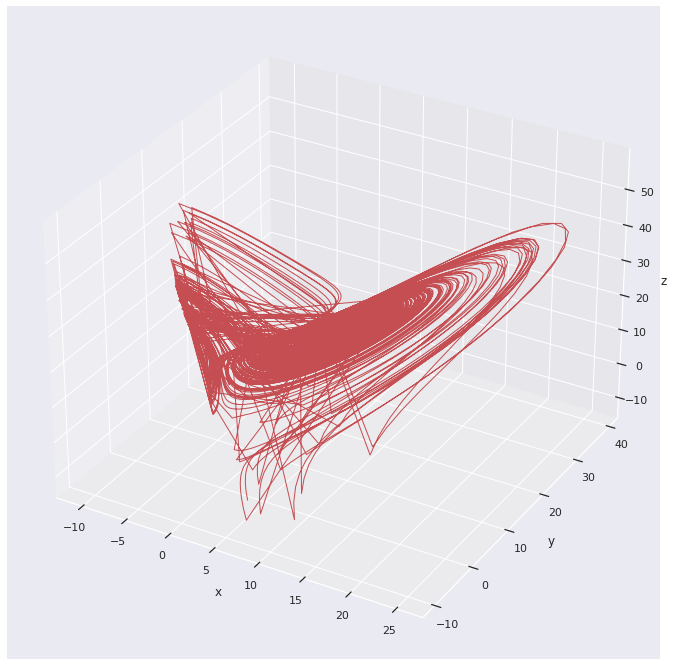

<Figure size 864x864 with 0 Axes>

In [18]:
#CHECK
# Train
predicted_classes_train_update = np.zeros(predictions_train.shape)
for jj in range(X_train.shape[1]):
    predicted_classes_train_update[:,jj,:] = predicted_classes_train


print('predicted_classes_train shape:', predicted_classes_train.shape)
print('predicted_classes_train_update shape:', predicted_classes_train_update.shape)
print('predictions_train shape :', predictions_train.shape)

# Test
predicted_classes_test_update = np.zeros(predictions_test.shape)
for jj in range(X_test.shape[1]):
    predicted_classes_test_update[:,jj,:] = predicted_classes_test


print('predicted_classes_test shape:', predicted_classes_test.shape)
print('predicted_classes_test_update shape:', predicted_classes_test_update.shape)
print('predictions_test shape :', predictions_test.shape)

X_parts_list = list()
y_parts_list = list()
#X_parts_list = np.zeros(predictions_test.shape)
#y_parts_list = np.zeros(predictions_test.shape)
num_kkkk = predictions_test[1,1,:].shape
num_kkkk = int(num_kkkk[0])
for kkkk in range(num_kkkk):
    X_manifold = []
    Elementindex = []
    elementindex = int(-1)
    while True:
        try:
            predicted_classes_train_update1 = []
            predicted_classes_train_update1 = predicted_classes_train_update[:,1,kkkk]
            predicted_classes_train_update1 = predicted_classes_train_update1.tolist()
            elementindex = predicted_classes_train_update1.index(1,elementindex+1) #here we can fix the dimension 1 because in this step procedure we look for only the occurence of a model
            Elementindex.append(elementindex)
        except  ValueError:
            break
    #print("Element index ", Elementindex)
    X_manifold = X_train.iloc[Elementindex]
    y_manifold = data_y.iloc[Elementindex]
    print('X_manifold',X_manifold)
    print('=============================')
    print('=============================')
    print('y_manifold',y_manifold)
    print('=============================')
    print('=============================')
    if kkkk == 0:
        ################ --- manifold 1 train --- #####################
        lorenz_TrueData_manifold1 = pd.DataFrame(np.real(X_manifold), columns=['xdot', 'ydot', 'zdot'])
        lorenz_TrueData_manifold1.index.names = ['index']
        lorenz_TrueData_manifold1.to_csv('lorenz_TrueData_manifold1.csv')
        np.savetxt("lorenz_TrueData_manifold1.csv", lorenz_TrueData_manifold1, delimiter=",")
    elif kkkk == 1:
        ################ --- manifold 2 train --- #####################
        lorenz_TrueData_manifold2 = pd.DataFrame(np.real(X_manifold), columns=['xdot', 'ydot', 'zdot'])
        lorenz_TrueData_manifold2.index.names = ['index']
        lorenz_TrueData_manifold2.to_csv('lorenz_TrueData_manifold2.csv')
        np.savetxt("lorenz_TrueData_manifold2.csv", lorenz_TrueData_manifold2, delimiter=",")
    #
    #X_manifold = X_manifold.tolist()
    X_parts_list.append(X_manifold)
    y_parts_list.append(y_manifold)
    print('X_parts_list',X_parts_list)
    print('=============================')
    print('=============================')
    print('y_parts_list',y_parts_list)
    #print('kkkk',kkkk)
    # %matplotlib widget
    # Plot PC-NN prediction(s)
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    from scipy import integrate
    from mpl_toolkits.mplot3d import Axes3D
    #
    rcParams.update({'font.size':10})
    plt.rcParams['figure.figsize'] = [12, 12]
    #
    num_traj = 1;
    #
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X_manifold_plot = np.matrix(X_manifold)
    print('X_manifold_plot shape:',X_manifold_plot.shape)
    #training
    xm1_star = np.array(X_manifold_plot[:,0])
    ym1_star = np.array(X_manifold_plot[:,1])
    zm1_star = np.array(X_manifold_plot[:,2])
    xm_star = xm1_star.flatten()
    ym_star = ym1_star.flatten()
    zm_star = zm1_star.flatten()
    #####################################################
    import numpy as np
    from sklearn.preprocessing import normalize
    plt.figure()
    ax.plot(xm_star, ym_star, zm_star, color='r', linewidth=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.scatter(x_plot[0,0], y_plot[0,0], color='r')
    #ax.view_init(18, -13)
    plt.show()


---

#### Get Binary Classes (Discontinuous Unit)
Maps deep classifier's outputs $\tilde{C}(x)\triangleq \hat{s}(x)$ to deep zero-sets $I_{(.5,1]}\circ \sigma_{\mbox{sigmoid}}(\tilde{C}(x))$.

#### Get PC-NN Prediction(s)
Comuptes $\sum_{n=1}^N \, \hat{f}(x)\cdot I_{K_n}$

In [19]:
# Train
predicted_classes_train_new = np.zeros(predictions_train.shape)
for jj in range(X_train.shape[1]):
    predicted_classes_train_new[:,jj,:] = predicted_classes_train
    
print('predicted_classes_train shape:', predicted_classes_train.shape)
print('predicted_classes_train_new shape:', predicted_classes_train_new.shape)
print('predictions_train shape :', predictions_train.shape)
Architope_prediction_y_train = (predictions_train*predicted_classes_train_new).sum(axis=-1)
print('Architope_prediction_y_train shape :', Architope_prediction_y_train.shape)
Architope_manifolds_prediction_y_train = (predictions_train*predicted_classes_train_new)
print('Architope_manifolds_prediction_y_train shape :', Architope_manifolds_prediction_y_train.shape)


# Test
predicted_classes_test_new = np.zeros(predictions_test.shape)
for jj in range(X_test.shape[1]):
    predicted_classes_test_new[:,jj,:] = predicted_classes_test
    
print('predicted_classes_test shape:', predicted_classes_test.shape)
print('predicted_classes_test_new shape:', predicted_classes_test_new.shape)
print('predictions_test shape :', predictions_test.shape)
Architope_prediction_y_test = (predictions_test*predicted_classes_test_new).sum(axis=-1)
print('Architope_prediction_y_test shape :', Architope_prediction_y_test.shape)
Architope_manifolds_prediction_y_test = (predictions_test*predicted_classes_test_new)
print('Architope_manifolds_prediction_y_test shape :', Architope_manifolds_prediction_y_test.shape)


predicted_classes_train shape: (43200, 2)
predicted_classes_train_new shape: (43200, 3, 2)
predictions_train shape : (43200, 3, 2)
Architope_prediction_y_train shape : (43200, 3)
Architope_manifolds_prediction_y_train shape : (43200, 3, 2)
predicted_classes_test shape: (4800, 2)
predicted_classes_test_new shape: (4800, 3, 2)
predictions_test shape : (4800, 3, 2)
Architope_prediction_y_test shape : (4800, 3)
Architope_manifolds_prediction_y_test shape : (4800, 3, 2)


In [20]:
print(X_train.shape, Architope_prediction_y_train.shape, y_train.shape)

(43200, 3) (43200, 3) (43200, 3)


In [21]:
y_test.shape

(4800, 3)

y_train_plot shape: (43200, 3)
y_test_plot shape: (4800, 3)
Architope_prediction_y_train_plot shape: (43200, 3)
Architope_prediction_y_test_plot shape: (4800, 3)


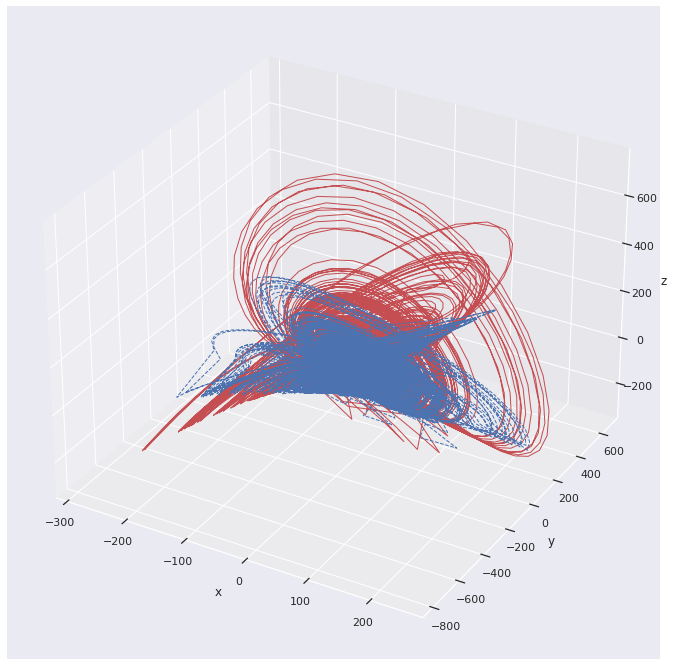

<Figure size 864x864 with 0 Axes>

In [22]:
# %matplotlib widget
# Plot PC-NN prediction(s)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

rcParams.update({'font.size':10})
plt.rcParams['figure.figsize'] = [12, 12]

num_traj = 1;

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y_train_plot = np.matrix(y_train)
y_test_plot = np.matrix(y_test)
print('y_train_plot shape:',y_train_plot.shape)
print('y_test_plot shape:',y_test_plot.shape)
Architope_prediction_y_train_plot = np.matrix(Architope_prediction_y_train)
Architope_prediction_y_test_plot = np.matrix(Architope_prediction_y_test)
print('Architope_prediction_y_train_plot shape:',Architope_prediction_y_train_plot.shape)
print('Architope_prediction_y_test_plot shape:',Architope_prediction_y_test_plot.shape)
#for jj in range(num_traj):
    #x, y, z = y_train_plot.T
#training
x1_star = np.array(y_train_plot[:,0])
y1_star = np.array(y_train_plot[:,1])
z1_star = np.array(y_train_plot[:,2])
x_star = x1_star.flatten()
y_star = y1_star.flatten()
z_star = z1_star.flatten()
# test
x1_test_star = np.array(y_test_plot[:,0])
y1_test_star = np.array(y_test_plot[:,1])
z1_test_star = np.array(y_test_plot[:,2])
x_test_star = x1_test_star.flatten()
y_test_star = y1_test_star.flatten()
z_test_star = z1_test_star.flatten()
#print(x.shape)
#x = np.reshape(x,7200)
#y = np.reshape(y,7200)
#z = np.reshape(z,7200)
# training
xd1_star = np.array(Architope_prediction_y_train_plot[:,0])
yd1_star = np.array(Architope_prediction_y_train_plot[:,1])
zd1_star = np.array(Architope_prediction_y_train_plot[:,2])
xd_star = xd1_star.flatten()
yd_star = yd1_star.flatten()
zd_star = zd1_star.flatten()
# test
xd1_test_star = np.array(Architope_prediction_y_test_plot[:,0])
yd1_test_star = np.array(Architope_prediction_y_test_plot[:,1])
zd1_test_star = np.array(Architope_prediction_y_test_plot[:,2])
xd_test_star = xd1_test_star.flatten()
yd_test_star = yd1_test_star.flatten()
zd_test_star = zd1_test_star.flatten()
#xd, yd, zd = Architope_prediction_y_train_plot.T
#####################################################
import numpy as np
from sklearn.preprocessing import normalize

#norm1_x = x / np.linalg.norm(x)
#norm2_x = normalize(x[:,np.newaxis], axis=0).ravel()
#print(np.all(norm1_x == norm2_x))
#norm1_y = y / np.linalg.norm(y)
#norm2_y = normalize(y[:,np.newaxis], axis=0).ravel()
#print(np.all(norm1_x == norm2_x))
#norm1_z = z / np.linalg.norm(z)
#norm2_z = normalize(z[:,np.newaxis], axis=0).ravel()
#print(np.all(norm1_x == norm2_x))
####################################################
plt.figure()
# training
#ax.plot(x_test, y_test, z_test, color='r', linewidth=1)
#ax.plot(xd_test, yd_test, zd_test, '--', lw=1)
ax.plot(x_star, y_star, z_star, color='r', linewidth=1)
ax.plot(xd_star, yd_star, zd_star, '--', lw=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
    #ax.scatter(x_plot[0,0], y_plot[0,0], color='r')

#ax.view_init(18, -13)
plt.show()

y_train_plot shape: (43200, 3)
y_test_plot shape: (4800, 3)
Architope_prediction_y_train_plot shape: (43200, 3)
Architope_prediction_y_test_plot shape: (4800, 3)


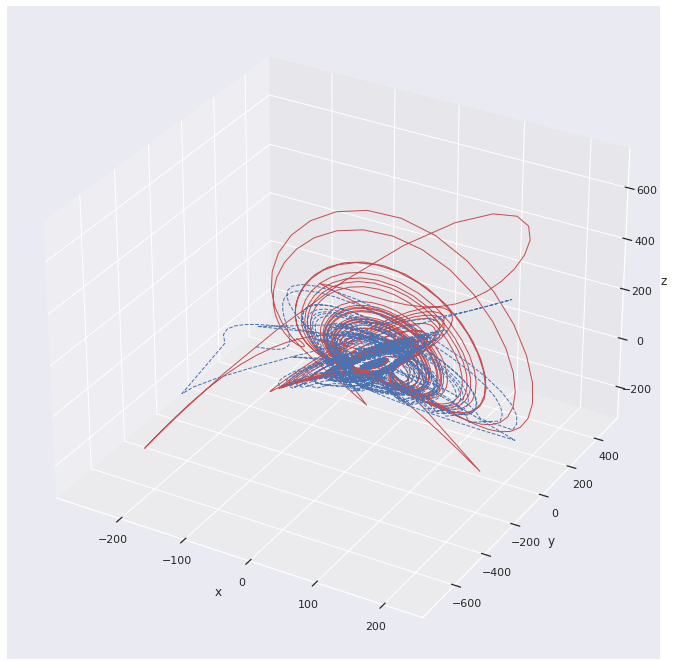

<Figure size 864x864 with 0 Axes>

In [23]:
# %matplotlib widget
# Plot PC-NN prediction(s)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

rcParams.update({'font.size':10})
plt.rcParams['figure.figsize'] = [12, 12]

num_traj = 1;

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y_train_plot = np.matrix(y_train)
y_test_plot = np.matrix(y_test)
print('y_train_plot shape:',y_train_plot.shape)
print('y_test_plot shape:',y_test_plot.shape)
Architope_prediction_y_train_plot = np.matrix(Architope_prediction_y_train)
Architope_prediction_y_test_plot = np.matrix(Architope_prediction_y_test)
print('Architope_prediction_y_train_plot shape:',Architope_prediction_y_train_plot.shape)
print('Architope_prediction_y_test_plot shape:',Architope_prediction_y_test_plot.shape)
#for jj in range(num_traj):
    #x, y, z = y_train_plot.T
#training
x1_star = np.array(y_train_plot[:,0])
y1_star = np.array(y_train_plot[:,1])
z1_star = np.array(y_train_plot[:,2])
x_star = x1_star.flatten()
y_star = y1_star.flatten()
z_star = z1_star.flatten()
# test
x1_test_star = np.array(y_test_plot[:,0])
y1_test_star = np.array(y_test_plot[:,1])
z1_test_star = np.array(y_test_plot[:,2])
x_test_star = x1_test_star.flatten()
y_test_star = y1_test_star.flatten()
z_test_star = z1_test_star.flatten()
#print(x.shape)
#x = np.reshape(x,7200)
#y = np.reshape(y,7200)
#z = np.reshape(z,7200)
# training
xd1_star = np.array(Architope_prediction_y_train_plot[:,0])
yd1_star = np.array(Architope_prediction_y_train_plot[:,1])
zd1_star = np.array(Architope_prediction_y_train_plot[:,2])
xd_star = xd1_star.flatten()
yd_star = yd1_star.flatten()
zd_star = zd1_star.flatten()
# test
xd1_test_star = np.array(Architope_prediction_y_test_plot[:,0])
yd1_test_star = np.array(Architope_prediction_y_test_plot[:,1])
zd1_test_star = np.array(Architope_prediction_y_test_plot[:,2])
xd_test_star = xd1_test_star.flatten()
yd_test_star = yd1_test_star.flatten()
zd_test_star = zd1_test_star.flatten()
#xd, yd, zd = Architope_prediction_y_train_plot.T
#####################################################
import numpy as np
from sklearn.preprocessing import normalize

#norm1_x = x / np.linalg.norm(x)
#norm2_x = normalize(x[:,np.newaxis], axis=0).ravel()
#print(np.all(norm1_x == norm2_x))
#norm1_y = y / np.linalg.norm(y)
#norm2_y = normalize(y[:,np.newaxis], axis=0).ravel()
#print(np.all(norm1_x == norm2_x))
#norm1_z = z / np.linalg.norm(z)
#norm2_z = normalize(z[:,np.newaxis], axis=0).ravel()
#print(np.all(norm1_x == norm2_x))
####################################################
plt.figure()
# training
ax.plot(x_test_star, y_test_star, z_test_star, color='r', linewidth=1)
ax.plot(xd_test_star, yd_test_star, zd_test_star, '--', lw=1)
#ax.plot(x_star, y_star, z_star, color='r', linewidth=1)
#ax.plot(xd_star, yd_star, zd_star, '--', lw=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
    #ax.scatter(x_plot[0,0], y_plot[0,0], color='r')

#ax.view_init(18, -13)
plt.show()

#### Write Predictions

Compute Performance

In [24]:
#y_test_in = y_test[:,jj]
#print(y_test[:,jj].shape,y_test_in.shape)

In [25]:
# Compute Peformance
print('y_train shape:',y_train.shape)
print('Architope_prediction_y_train shape:', Architope_prediction_y_train.shape)
print('y_test shape:',y_test.shape)
print('Architope_prediction_y_test shape:', Architope_prediction_y_test.shape)
performance_Architope_C = np.zeros((3,3))
for jj in range(3):
    performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train[:,jj],
                                    y_test_hat_in=Architope_prediction_y_test[:,jj],
                                    y_train_in=y_train[:,jj],
                                    y_test_in=y_test[:,jj])
    # Update User
    print('dimension:',jj,performance_Architope)
    #performance_Architope = np.sum(performance_Architope_C, axis=1)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))


y_train shape: (43200, 3)
Architope_prediction_y_train shape: (43200, 3)
y_test shape: (4800, 3)
Architope_prediction_y_test shape: (4800, 3)
dimension: 0            train       test
MAE     1.022678   1.082125
MSE     3.991908   4.091656
MAPE   28.358767  23.613829
SMAPE  12.456513  12.744963
dimension: 1              train         test
MAE      20.678640    22.713378
MSE    1703.354277  1756.833606
MAPE    465.117091   320.039023
SMAPE    71.240025    87.357387
dimension: 2             train        test
MAE     14.480512   15.899264
MSE    895.587901  881.464825
MAPE   144.722426  216.751118
SMAPE   41.798693   54.717111


## Notes for the user update reported above
- dimension 0 corrispond to the x dimension
- dimension 1 corrispond to the y dimension
- dimension 2 corrispond to the z dimension

---

---

---

## Save data

In [26]:
import pandas as pd

print(xd_star.shape)
print(yd_star.shape)
print(zd_star.shape)
row = np.array(['xdot', 'ydot', 'zdot']).T
row_n = row.shape[0] ##last row
Xdot_lorenz_outputPCNN_dataframe = pd.DataFrame(Architope_prediction_y_train_plot, columns=['xdot', 'ydot', 'zdot'])
Xdot_lorenz_outputPCNN_dataframe.index.names = ['index']
Xdot_lorenz_outputPCNN_dataframe.to_csv('lorenz_PCNN_train.csv')
np.savetxt("lorenz_PCNN_train.csv", Xdot_lorenz_outputPCNN_dataframe, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_PCNN.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)

#########################################################
Xdot_lorenz_outputPCNN_dataframe_test = pd.DataFrame(Architope_prediction_y_test_plot, columns=['xdot', 'ydot', 'zdot'])
Xdot_lorenz_outputPCNN_dataframe_test.index.names = ['index']
Xdot_lorenz_outputPCNN_dataframe_test.to_csv('lorenz_PCNN_test.csv')
np.savetxt("lorenz_PCNN_test.csv", Xdot_lorenz_outputPCNN_dataframe_test, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_PCNN.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)
 
# print dataframes.
Xdot_lorenz_outputPCNN_dataframe
#########################################################
############## -- save data manifold -- #################
#########################################################
print('Architope_manifolds_prediction_y_train',Architope_manifolds_prediction_y_train.shape)
print('Architope_manifolds_prediction_y_test',Architope_manifolds_prediction_y_test.shape)
################ --- manifold 1 train --- #####################
Architope_manifold1_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,0], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold1_prediction_y_train.index.names = ['index']
Architope_manifold1_prediction_y_train.to_csv('lorenz_PCNN_manifold1.csv')
np.savetxt("lorenz_PCNN_manifold1.csv", Architope_manifold1_prediction_y_train, delimiter=",")
################ --- manifold 2 train --- #####################
Architope_manifold2_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,1], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold2_prediction_y_train.index.names = ['index']
Architope_manifold2_prediction_y_train.to_csv('lorenz_PCNN_manifold2.csv')
np.savetxt("lorenz_PCNN_manifold2.csv", Architope_manifold2_prediction_y_train, delimiter=",")
################ --- manifold 3 train --- #####################
#Architope_manifold3_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,2], columns=['xdot', 'ydot', 'zdot'])
#Architope_manifold3_prediction_y_train.index.names = ['index']
#Architope_manifold3_prediction_y_train.to_csv('lorenz_PCNN_manifold3.csv')
#np.savetxt("lorenz_PCNN_manifold3.csv", Architope_manifold3_prediction_y_train, delimiter=",")

################ --- manifold 1 test --- #####################
Architope_manifold1_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,0], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold1_prediction_y_test.index.names = ['index']
Architope_manifold1_prediction_y_test.to_csv('lorenz_PCNN_manifold1_test.csv')
np.savetxt("lorenz_PCNN_manifold1_test.csv", Architope_manifold1_prediction_y_test, delimiter=",")
################ --- manifold 2 test --- #####################
Architope_manifold2_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,1], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold2_prediction_y_test.index.names = ['index']
Architope_manifold2_prediction_y_test.to_csv('lorenz_PCNN_manifold2_test.csv')
np.savetxt("lorenz_PCNN_manifold2_test.csv", Architope_manifold2_prediction_y_test, delimiter=",")
################ --- manifold 3 test --- #####################
#Architope_manifold3_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,2], columns=['xdot', 'ydot', 'zdot'])
#Architope_manifold3_prediction_y_test.index.names = ['index']
#Architope_manifold3_prediction_y_test.to_csv('lorenz_PCNN_manifold3_test.csv')
#np.savetxt("lorenz_PCNN_manifold3_test.csv", Architope_manifold3_prediction_y_test, delimiter=",")


(43200,)
(43200,)
(43200,)
Architope_manifolds_prediction_y_train (43200, 3, 2)
Architope_manifolds_prediction_y_test (4800, 3, 2)


### Model Complexity/Efficiency Metrics

In [27]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

       L-time      P-time  N_params_expt  AIC-like     Eff
0  203.686689  110.691283              6     6.467  28.488


---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [28]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [29]:
parameters = {'penalty': ['none','l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [30]:
# Update User on shape of learned partition
print(partition_labels_training)

[[1 1 0]
 [1 1 0]
 [1 1 0]
 ...
 [0 0 0]
 [0 0 0]
 [1 0 0]]


In [31]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

Training classifier and generating partition!


ValueError: bad input shape (43200, 3)

#### Write Predicted Class(es)

In [ ]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [ ]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [ ]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

---
## Bagged Feed-Forward Networks (ffNNs)

In [ ]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [ ]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [ ]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [ ]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

In [ ]:
print("Random Partition: Generated!...Feature Generation Complete!")

## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [ ]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

In [ ]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [ ]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                      n_jobs = n_jobs, 
                                                                                      n_iter = n_iter, 
                                                                                      param_grid_in = param_grid_Vanilla_Nets, 
                                                                                      X_train=X_train, 
                                                                                      y_train=data_y, 
                                                                                      X_test_partial=X_train,
                                                                                      X_test=X_test,
                                                                                      NOCV=True)

In [ ]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [ ]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

#### Evaluate Performance

In [ ]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

#### Compute Required Training Time(s)

In [ ]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [ ]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

## Run: Gradient Boosted Random Forest Regression

In [ ]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

## Training Result(s)
#### (Update) Write Required Training Times

In [ ]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [ ]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

### Model Complexity/Efficiency Metrics

In [ ]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

# Summary

In [ ]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='slategrey',label=r'$f_1(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)
plt.scatter(x_2,y_2,color='dodgerblue',label=r'$f_2(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)
#
#jj = 0
#for j in range(0,len(x)-1,10):
#    jj = jj+1;
#    plt.scatter(x[j],y_hat_train_Vanilla_ffNN[jj], color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
#    plt.scatter(x[j],Architope_prediction_y_train[jj], color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO.pdf', format='pdf')

In [ ]:
#import numpy as np
#print(len(x)-1,len(y_hat_train_Vanilla_ffNN))
#print(np.linspace(10,len(x)-1,len(y_hat_train_Vanilla_ffNN)))
#def my_func(low,up,leng):
#    list = []
#    step = int((up - low) / float(leng))
#    print(step)
#    for i in range(leng):
#        list.append(int(low))
#        low = int(low + step)
#    return list
#
#my_list = my_func(0,len(x)-1,len(y_hat_train_Vanilla_ffNN))
#res = [int(item) for item in my_list]
#
#print(my_list)
#print(type(my_list))
#
#indice_prova = 10,len(x)-1,len(y_hat_train_Vanilla_ffNN);
#for j in range(0,len(x)-1,10):
#    print(j,np.matrix(x[j]).shape)
    

---
# Fin
---

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
dfX_train = pd.DataFrame(X_train,columns=['x','y','z'])
dfX_train.plot(x = 'x', y='y', z='z', kind = 'scatter')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/lorenz.pdf', format='pdf')